<div>
<img src="https://www.nasa.gov/wp-content/uploads/2024/07/osdr-gl4hs-logo.png" width="600"/>
</div>

# **NOTEBOOK: Performing gene set enrichment analysis (GSEA) and over-representation analysis (ORA)**
In this notebook, you will run statistical tests to determine which gene sets are over-represented by the differentially expressed genes you identified in the previous notebook. You'll also conduct gene set enrichment analysis which uses the gene expression data itself to determine which gene sets are enriched by genes differentially expressed between 2 groups (e.g. spaceflight and ground control).

## **Objectives of this notebook**
The primary objective of this notebook is to use Python's gseapy implementations of GSEA and ORA to find gene sets which are statistically significantly enriched by the genes that are differentially expressed between ground control and space flight groups in your dataset.

GSEA and ORA help us better understand which biological, cellular, and molecular processes and pathways explain the phenotypic differences we may observe between space flight and ground control mice. By extension, because the mouse is a model mammal organism which shares many body plans and orthologous genes with humans, we may infer how spaceflight may impact astronaut health. You can read more about GSEA in this [Wikipedia article](https://en.wikipedia.org/wiki/Gene_set_enrichment_analysis).

We use a library called enrichR which is written for R and Python, and has an [online portal](https://maayanlab.cloud/Enrichr/) you can query. You can learn more about enrichR and gene set enrichment analysis in this [YouTube video](https://www.youtube.com/watch?v=H1cUs6pql9s). The `gseapy` Python module has implementations for both GSEA as well as ORA. The major difference between these 2 approaches is that GSEA takes gene expression data as input and ORA takes a list of genes as input. As such, ORA is a more flexible tool and can be used to find gene sets and pathways  enriched by a list of genes regardless of how that list is derived. Here is a [Website](https://rnabio.org/module-08-scrna/0008/05/01/Gene_set_enrichment/) which discusses the differences between these 2 approaches.

## **UNIX commands introduced in this notebook**

N/A

# Prepare the runtime environment for the notebook

In [ ]:
# mount google drive
from google.colab import drive
drive.flush_and_unmount()
drive.mount("mnt")

Drive not mounted, so nothing to flush and unmount.
Mounted at mnt


In [ ]:
# time the notebook
import datetime
start_time = datetime.datetime.now()
print('notebook start time: ', start_time.strftime('%Y-%m-%d %H:%M:%S'))

notebook start time:  2025-08-23 21:52:56


In [ ]:
# define OSD dataset number to use for this notebook
OSD_DATASET='254'
GLDS_DATASET='254'

In [ ]:
# define factors for experiment

# young GC vs old GC
config_1 = {
    'experiment name': 'young_GC_vs_old_GC',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '32'}
}

# young FLT vs old FLT
config_2 = {
    'experiment name': 'young_FLT_vs_old_FLT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '32'}
}

# young GC vs young FLT
config_3 = {
    'experiment name': 'young_GC_vs_young_FLT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '10 to 12'}
}

# old GC vs old FLT
config_4 = {
    'experiment name': 'old_GC_vs_old_FLT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '32'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '32'}
}

# FLT vs GC
config_5 = {
    'experiment name': 'FLT_vs_GC',
    'factor_list': ['Factor Value[Spaceflight]'],
    'group_A': {'Factor Value[Spaceflight]': 'Space Flight'},
    'group_B': {'Factor Value[Spaceflight]': 'Ground Control'}
}

# YNG vs OLD
config_6 = {
    'experiment name': 'YNG_vs_OLD',
    'factor_list': ['Factor Value[Age]'],
    'group_A': {'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Age]': '32'}
}

# FLIGHT LONG vs FLIGHT SHORT
config_8 = {
    'experiment name': 'FLIGHT_LONG_vs_FLIGHT_SHORT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Duration]'],
    'group_A': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Duration]': '~25'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Duration]': '~75'}
}

config = config_8

In [ ]:
# define output dir
OUTPUT_DIR="/content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/" + OSD_DATASET + "/" + config['experiment name']

In [ ]:
# set DGEA_DIR to get DEGs
import os
DGEA_DIR=OUTPUT_DIR + "/DGEA/"
if not os.path.exists(DGEA_DIR):
  raise Exception("STOP! You must finish the preceding notebook before running this one")

In [ ]:
import os
META_DIR=OUTPUT_DIR + "/META/"
if not os.path.exists(META_DIR):
  raise Exception("STOP! You must finish the preceding notebook before running this one")

In [ ]:
import os
GSEA_DIR=OUTPUT_DIR + "/GSEA/"
if os.path.exists(GSEA_DIR):
  !rm -rf {GSEA_DIR}
!mkdir -p {GSEA_DIR}

In [ ]:
# install packages and import the modules needed to do DGEA
!pip install gseapy==1.1.8 --no-cache
import gseapy as gp
from gseapy import Msigdb
!pip install mygene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.5/591.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 940.0 kB/s eta 0:00:00


# Define Python methods

In [ ]:
# define method to run ORA
def run_ora( gene_results, gene_set_list, background_genes=[], display_cols=['Term', 'Genes', 'Adjusted P-value', 'Combined Score'], sleep_time=5, retries=10):
  counter = 0
  import time
  enr = None
  gsea = None
  while counter < retries:
    try:
      # use enrichR to get gene ontology terms for molecular function, cellular components, and biological processes
      # sometimes the call fails, so just re-run the cell after a few seconds
      enr = gp.enrichr(gene_list=list(gene_results),
                      gene_sets=gene_set_list,
                      organism='mouse',
                      outdir=None,
                      )
    except:
      time.sleep(sleep_time)
      counter += 1
      continue
    break

  if not enr is None:
    # show top 10 results with adjusted p-value less than 0.05
    # other cols to display ['Term', 'Overlap', 'Genes', 'Adjusted P-value']
    gsea = enr.results[enr.results['Adjusted P-value'] < 0.05][display_cols]
  else:
    print('gsea failed')
  return gsea, enr

In [ ]:
# define method to run gseapy
def run_run_ora(deg_gene_symbols, background_gene_symbols, available_gene_sets, gene_set_list):
  gene_sets = list()
  for gene_set in gene_set_list:
    if gene_set not in available_gene_sets:
      print('gene set NOT found: ', gene_set)
    else:
      print('gene set found: ', gene_set)
      gene_sets.append(gene_set)
  results, enr = run_ora(deg_gene_symbols, gene_sets, background_gene_symbols)

  return results, enr

In [ ]:
# define method to convert gene ids to symbols
def get_symbols_from_ids(gene_list):
  import mygene

  symbol_list = list()
  mg = mygene.MyGeneInfo()
  ginfo = mg.querymany(gene_list, scopes='ensembl.gene')
  seen_genes = list()
  for g in ginfo:
    if g['query'] in seen_genes:
      continue
    if not 'symbol' in g:
      symbol_list.append(g['query'])
    else:
      symbol_list.append(g['symbol'])
    seen_genes.append(g['query'])
  return symbol_list

In [ ]:
# define method to transpose a dataframe
def transpose_df(df, cur_index_col, new_index_col):
  df = df.set_index(cur_index_col).T
  df.reset_index(level=0, inplace=True)
  cols = [new_index_col] + list(df.columns)[1:]
  df.columns = cols
  return df

# Read in data from google drive

In [ ]:
# read DEGs from file
import os
deg_gene_symbols = []
file_path = os.path.join(DGEA_DIR, 'deg_genes.txt')
if not os.path.exists(file_path):
  raise Exception("STOP! You must finish the preceding notebook before running this one")
with open(file_path, 'r') as f:
  for line in f:
    deg_gene_symbols.append(line.strip())

In [ ]:
# pring the first 10 degs
print('number of DEGs: ', len(deg_gene_symbols))
deg_gene_symbols[:10]

number of DEGs:  1496


['Th',
 'Clec2g',
 'Rnf17',
 'Wap',
 'S100a3',
 'C1ql4',
 'Slc26a3',
 'Dlx3',
 'Hoxc13',
 'Dsg4']

These genes are Ensembl gene symbols. You can learn more about Ensembl gene naming [here](https://www.informatics.jax.org/mgihome/nomen/gene.shtml).


We are going to submit the list of "background" genes along with the differentially expressed genes to the `gseapy` Enrichr tool. You can read more about background genes on this [biostars thread](https://www.biostars.org/p/17628/).

In [ ]:
# read background genes from file
background_gene_symbols = []
import os
file_path = os.path.join(DGEA_DIR, 'background_genes.txt')
if not os.path.exists(file_path):
  raise Exception("STOP! You must finish the preceding notebook before running this one")
with open(file_path, 'r') as f:
  for line in f:
    background_gene_symbols.append(line.strip())

In [ ]:
# print the first 10 background genes
print('number of background genes: ', len(background_gene_symbols))
background_gene_symbols[:10]

number of background genes:  15620


['Cdc45',
 'H19',
 'Apoh',
 'Tbx2',
 'Tbx4',
 'Ngfr',
 'Wnt3',
 'Wnt9a',
 'Axin2',
 'Brat1']

In [ ]:
# read in expr_df from google drive
import pandas as pd
expr_df = pd.read_csv(DGEA_DIR + '/expr_df_factors.csv')

# transpose dataframe so it's genes x samples
expr_df_t = transpose_df(expr_df, 'sample', 'Gene')

genes = list(expr_df_t['Gene'])

# convert gene ids to gene symbols
gene_symbols = get_symbols_from_ids(genes)

# then cast gene names to upper case
gene_symbols_upper = [gene.upper() for gene in gene_symbols]
expr_df_t['Gene'] = gene_symbols_upper

# print first 5 rows of expression matrix
expr_df_t.head()


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-15620 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,Gene,Mmus_C57-6J_SKN_FLT_25days_Rep1_F1,Mmus_C57-6J_SKN_FLT_25days_Rep2_F5,Mmus_C57-6J_SKN_FLT_25days_Rep3_F9,Mmus_C57-6J_SKN_FLT_25days_Rep4_F13,Mmus_C57-6J_SKN_FLT_25days_Rep5_F17,Mmus_C57-6J_SKN_FLT_75days_Rep1_F3,Mmus_C57-6J_SKN_FLT_75days_Rep2_F7,Mmus_C57-6J_SKN_FLT_75days_Rep3_F11,Mmus_C57-6J_SKN_FLT_75days_Rep4_F15,...,Mmus_C3H-HeJ_SKN_FLT_25days_Rep1_F2,Mmus_C3H-HeJ_SKN_FLT_25days_Rep2_F6,Mmus_C3H-HeJ_SKN_FLT_25days_Rep3_F10,Mmus_C3H-HeJ_SKN_FLT_25days_Rep4_F14,Mmus_C3H-HeJ_SKN_FLT_25days_Rep5_F18,Mmus_C3H-HeJ_SKN_FLT_75days_Rep1_F4,Mmus_C3H-HeJ_SKN_FLT_75days_Rep2_F8,Mmus_C3H-HeJ_SKN_FLT_75days_Rep3_F12,Mmus_C3H-HeJ_SKN_FLT_75days_Rep4_F16,Mmus_C3H-HeJ_SKN_FLT_75days_Rep5_F20
0,CDC45,63.0,58.0,66.0,209.0,179.0,81.0,103.0,176.0,160.0,...,94.0,102.0,229.0,237.0,415.0,81.0,89.0,210.0,243.0,319.0
1,H19,940.0,5524.0,4607.0,7479.0,17792.0,2078.0,3451.0,7579.0,4907.0,...,1633.0,2397.0,1032.0,10543.0,2052.0,5679.0,4841.0,8222.0,6149.0,5012.6
2,APOH,0.0,2.0,0.0,0.0,2.0,1.0,4.0,3.0,1.0,...,0.0,3.0,0.0,3.0,3.0,4.0,2.0,3.0,0.0,3.0
3,TBX2,21.0,13.0,11.0,100.0,68.0,20.0,18.0,103.0,125.0,...,5.0,8.0,21.0,114.0,107.0,16.0,13.0,68.0,76.0,48.0
4,TBX4,1.0,14.0,13.0,26.0,61.0,8.0,14.0,32.0,21.0,...,3.0,1.0,10.0,15.0,13.0,13.0,19.0,31.0,19.0,14.0


# Run gene set enrichment analysis
We will use gsea from the `gseapy` Python package to perform gene set enrichment analysis. The code in this section was drived from [this example](https://gseapy.readthedocs.io/en/latest/gseapy_example.html#GSEA-Example) in the gseapy documentation.

In [ ]:
# read in factors from previous notebook
factors = pd.read_csv(DGEA_DIR + '/factors.csv')
classes = [str(i) for i in list(factors['factor'])]
print('factors shape: ', factors.shape)
print('classes: ', classes)


factors shape:  (20, 2)
classes:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


In [ ]:
# define gene sets to explore in GSEA
go_gene_sets = ['GO_Molecular_Function_2025', \
                 'GO_Biological_Process_2025', \
                 'GO_Cellular_Component_2025']

# run GSEA experiment
go_gsea_res = gp.gsea(data=expr_df_t,
                 gene_sets=go_gene_sets,
                 cls= classes,
                 # set permutation_type to phenotype if samples >=15
                 outdir=None,
                 method='signal_to_noise',
                 threads=2, seed= 7)

print(go_gsea_res)

# filter results based on FWER p-val < 0.05
go_gsea_results = go_gsea_res.res2d[go_gsea_res.res2d['FWER p-val'] < 0.05]

# define columns to display in output
display_cols = ['Term', 'Lead_genes', 'NES', 'FWER p-val']

# print head of GSEA results
print('gsea results: ', go_gsea_results[display_cols].head())

# save the GO GSEA results to google drive
go_gsea_results.to_csv(GSEA_DIR + '/go_gsea_results.csv', index=None)


2025-08-23 21:53:57,218 [WARNING] Found duplicated gene names, values averaged by gene names!
/usr/local/lib/python3.12/dist-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


gsea results:                                                  Term  \
0  GO_Biological_Process_2025__Lipid Modification...   
1  GO_Cellular_Component_2025__Aggresome (GO:0016...   

                         Lead_genes       NES FWER p-val  
0  PLPPR4;SGPP2;CYP1A1;MBOAT4;PLPP4 -2.067056      0.013  
1                            SFMBT2  -2.02049       0.03  


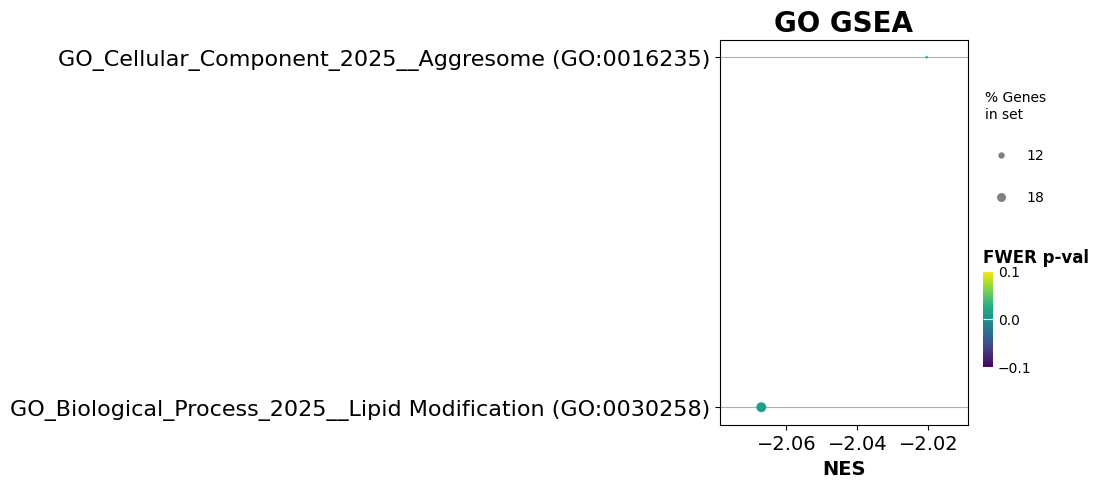

In [ ]:
# plot GO GSEA results in dot plot
from gseapy import dotplot
import matplotlib.pyplot as plt

if go_gsea_results.empty:
  print('no GO GSEA results to plot')
else:
  ax = dotplot(go_gsea_results,
              column="FWER p-val",
              title='GO GSEA',
              cmap=plt.cm.viridis,
              size=5,
              figsize=(4,5), cutoff=1)

  # save dotplot to google drive
  ax.get_figure().savefig(GSEA_DIR + '/go_gsea_dotplot.png')

The smaller the FWER p-value, the more significant the statistical enrichment. The higher the percentage of genes in the gene set, the larger the dot in the plot. The horizontal axis is the normalized enrichment score (NES).

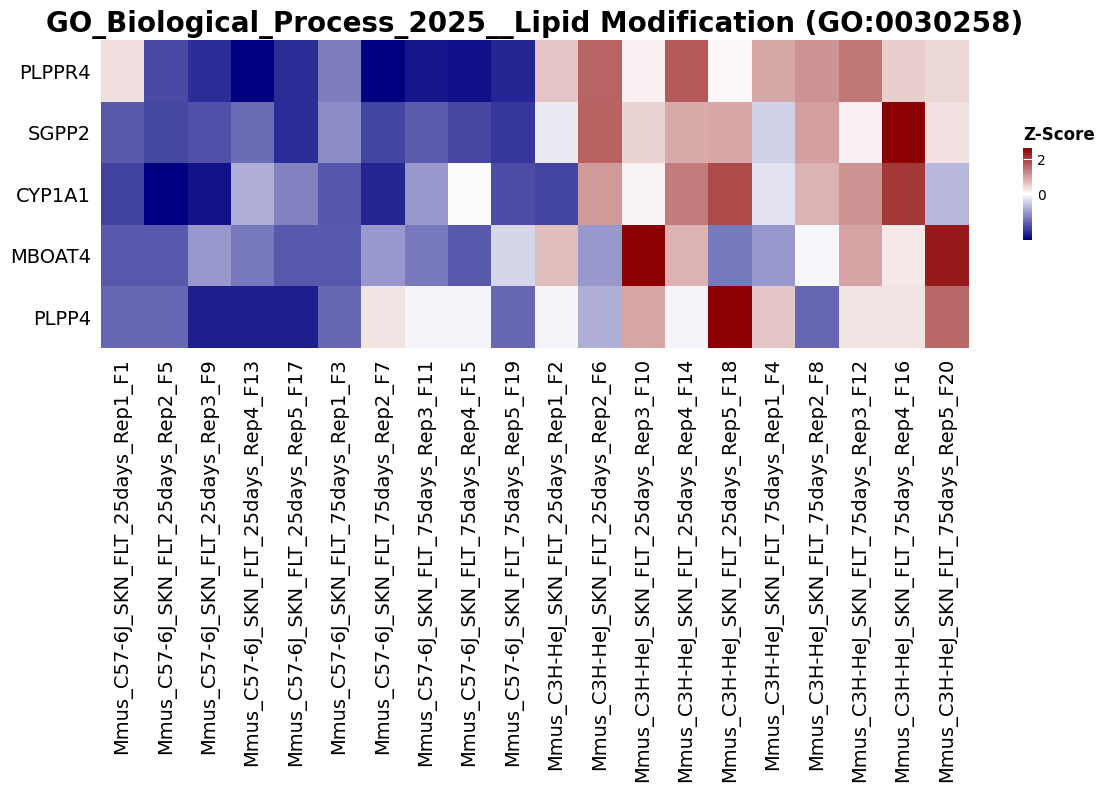

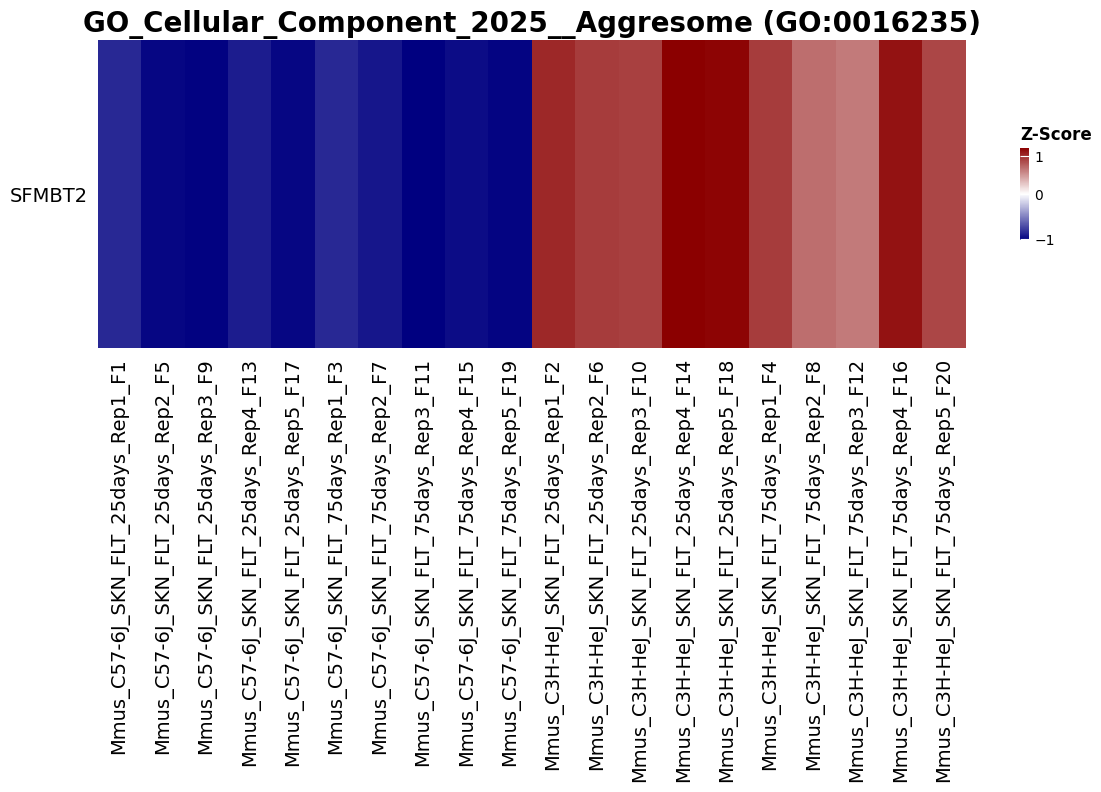

In [ ]:
# plot GO GSEA results in heatmap
from gseapy import heatmap
if go_gsea_results.empty:
  print('no GO GSEA results to plot')
else:
  terms = go_gsea_results.Term

  for i in range(len(go_gsea_results)):
    genes = go_gsea_results.Lead_genes[i].split(";")
    ax = heatmap(df = go_gsea_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4))

  # save heatmap data to google drive
  go_gsea_res.heatmat.to_csv(GSEA_DIR + '/go_gsea_heatmap.csv', index=None)

  # save heatmap figure to google drive
  ax.get_figure().savefig(GSEA_DIR + '/go_gsea_heatmap.png')

In [ ]:
geo_gene_sets = ['Disease_Perturbations_from_GEO_down', \
                 'Disease_Perturbations_from_GEO_up']

geo_gsea_res = gp.gsea(data=expr_df_t,
                 gene_sets=geo_gene_sets,
                 cls= classes,
                 # set permutation_type to phenotype if samples >=15
                 outdir=GSEA_DIR,
                 method='signal_to_noise',
                 threads=2, seed= 7)

# filter results based on FWER p-val
geo_gsea_results = geo_gsea_res.res2d[geo_gsea_res.res2d['FWER p-val'] < 0.05]

# define columns to display in output
display_cols = ['Term', 'Lead_genes', 'NES', 'FWER p-val']

# print top 10 GSEA results
print('head of geo gsea results: ', geo_gsea_results[display_cols].head())

# save the GO GSEA results to google drive
geo_gsea_results.to_csv(GSEA_DIR + '/geo_gsea_results.csv', index=None)

2025-08-23 21:55:58,791 [WARNING] Found duplicated gene names, values averaged by gene names!
/usr/local/lib/python3.12/dist-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


head of geo gsea results:                                                  Term  \
0  Disease_Perturbations_from_GEO_down__Fibrosis ...   

                                          Lead_genes       NES FWER p-val  
0  GM5859;GM7819;CD300LD;B3GNT3;H2-Q6;NXPE2;RAB6B...  2.104263      0.009  


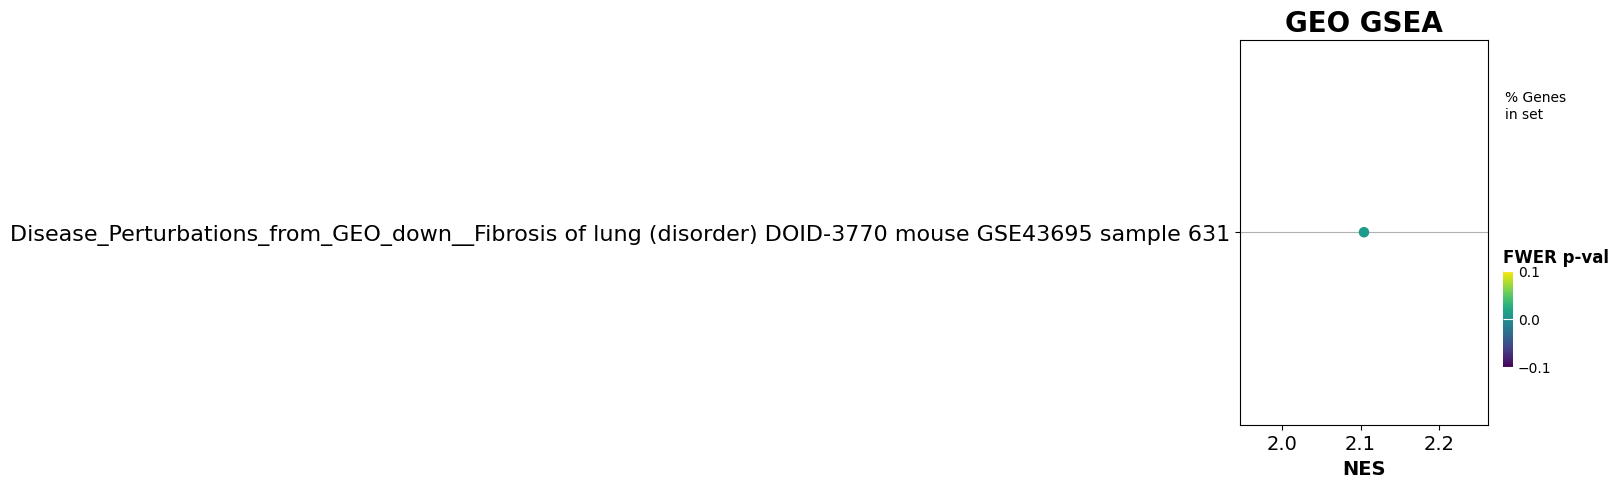

In [ ]:
# create the dot plot
from gseapy import dotplot
import matplotlib.pyplot as plt
if geo_gsea_results.empty:
  print('no GEO GSEA results to plot')
else:
  ax = dotplot(geo_gsea_results,
              column="FWER p-val",
              title='GEO GSEA',
              cmap=plt.cm.viridis,
              size=5,
              figsize=(4,5), cutoff=1)

  # save figure to google drive
  ax.get_figure().savefig(GSEA_DIR + '/geo_gsea_dotplot.png')

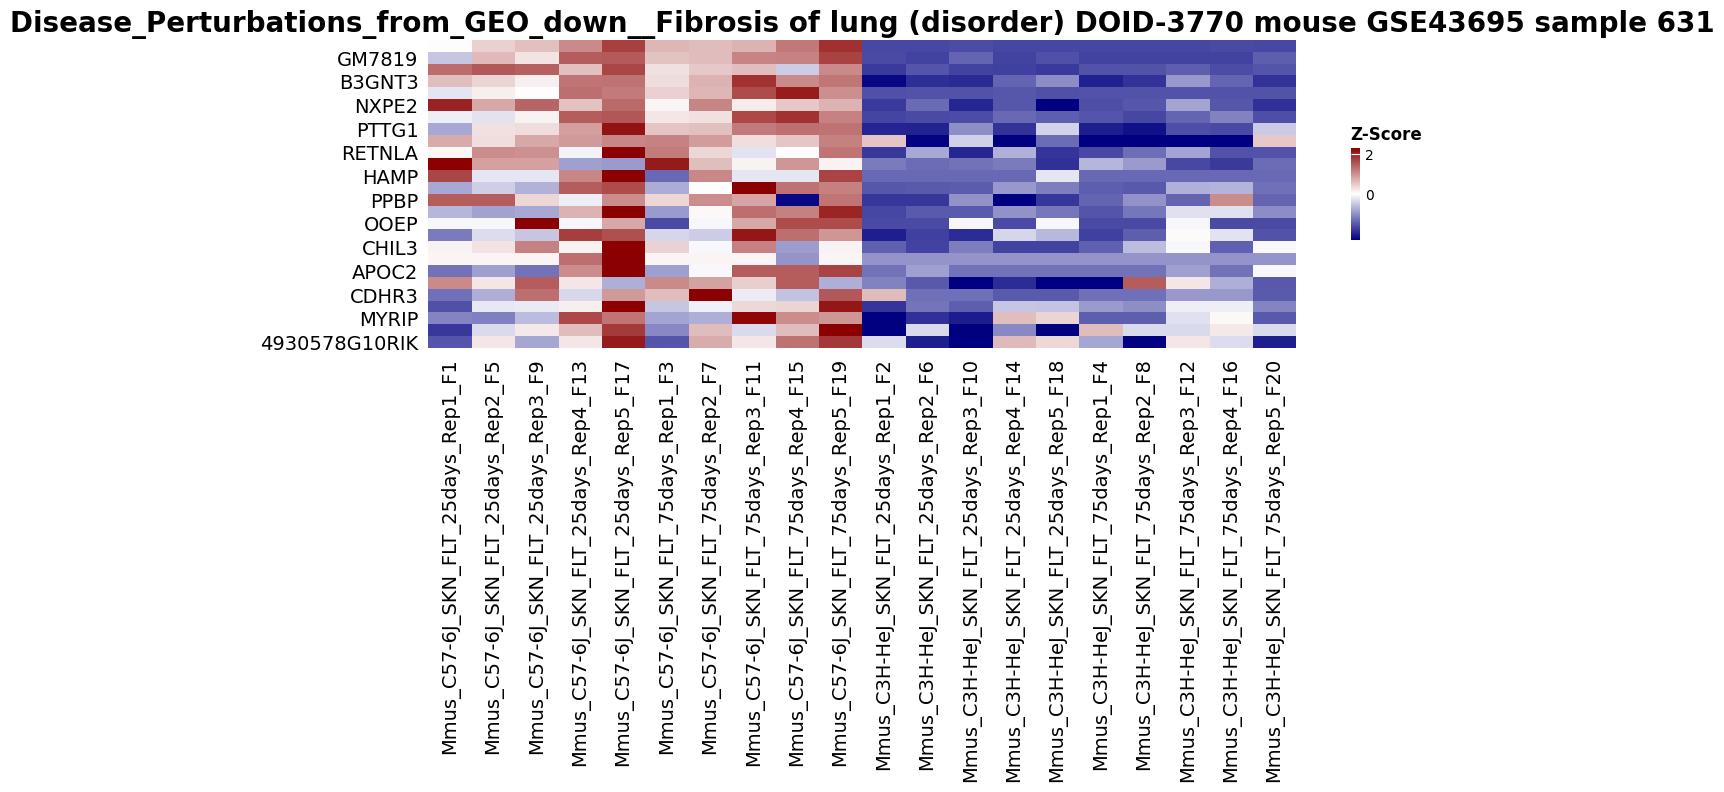

In [ ]:
# plot GEO GSEA results in heatmap
from gseapy import heatmap
if geo_gsea_results.empty:
  print('no GEO GSEA results to plot')
else:
  terms = geo_gsea_results.Term

  for i in range(len(geo_gsea_results)):
    genes = geo_gsea_results.Lead_genes[i].split(";")
    ax = heatmap(df = geo_gsea_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4))

  # save heatmap data to google drive
  geo_gsea_res.heatmat.to_csv(GSEA_DIR + '/geo_gsea_heatmap.csv', index=None)

  # save heatmap figure to google drive
  ax.get_figure().savefig(GSEA_DIR + '/geo_gsea_heatmap.png')

# Run over-representation analysis

We will use Enrichr from the `gseapy` Python package to perform over-representation analysis. You can learn more about Enrichr [here](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-128).

In [ ]:
# get list of all available gene sets to query
list_of_gene_sets=gp.get_library_name(organism='Mouse')
print('number of gene sets to analyze: ', len(list_of_gene_sets))
print(list_of_gene_sets)

number of gene sets to analyze:  218
['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'COMPARTMENTS_Curated_2025', 'COMPARTMENTS_Experimental_2025', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screen

We are only going to look at a few of those gene sets, but you should feel free to add more gene sets from the list above to the list below. You can learn more about these gene sets [here](https://maayanlab.cloud/Enrichr/#libraries).

In [ ]:
# verify the gene sets we're exploring are still part of the supported libraries
# if one is not available, terminate the notebook!
available_gene_sets = list()

for gene_set in ['GO_Molecular_Function_2025', \
                 'GO_Biological_Process_2025', \
                 'GO_Cellular_Component_2025', \
                 'Disease_Perturbations_from_GEO_down', \
                 'Disease_Perturbations_from_GEO_up']:
  if gene_set not in list_of_gene_sets:
    print('gene set not found!:', gene_set)
    raise Exception("STOP! remove this gene set from the gene_set list above as it appears to be unavailable")
  else:
    print('gene set found: ', gene_set)
    available_gene_sets.append(gene_set)

gene set found:  GO_Molecular_Function_2025
gene set found:  GO_Biological_Process_2025
gene set found:  GO_Cellular_Component_2025
gene set found:  Disease_Perturbations_from_GEO_down
gene set found:  Disease_Perturbations_from_GEO_up


In [ ]:
# define dictionary to hold results and enrichR object to hold enrichR data
enrichr_results = {}
enrichr = {}

**NOTE**

The calls to the online Enrichr Web Service may fail (it's a free Web service that has been known to periodically fail). If they do fail, you can copy the list of differentially expressed genes into your favorite editor (like MS Word or textedit or Google Docs) and create a list such as the following by removing the `'`, `[`, `]` characters from the list. Then use online pathway and gene set enrichment tools such as [DAVID](https://davidbioinformatics.nih.gov/summary.jsp), [MSigDB](https://www.gsea-msigdb.org/gsea/login.jsp), and [ShinyGO](https://bioinformatics.sdstate.edu/go/).



In [ ]:
# Get GO results
# print the top 10
gene_sets = ['GO_Molecular_Function_2025','GO_Cellular_Component_2025', 'GO_Biological_Process_2025']
enrichr_results['GO'], enrichr['GO'] = run_run_ora(deg_gene_symbols, background_gene_symbols, available_gene_sets, gene_sets)
enrichr_results['GO'].head(10)


gene set found:  GO_Molecular_Function_2025
gene set found:  GO_Cellular_Component_2025
gene set found:  GO_Biological_Process_2025


,Term,Genes,Adjusted P-value,Combined Score


The output includes each of the gene ontologies that are over-represented by your list of significantly differentially expressed genes. The ORA output is sorted by adjusted p-value.

Each over-represented gene set includes your genes which belong to that gene set, along with the adjusted p-value representing the significance of the enrichment. Recall that, in DGEA where we are conducting the same statistical test thousands of times, we needed to adjust the p-value to account for the inflated number of false positives due to multiple testing. Similarly, here we are also conducting the same statistical test thousands of times -- once per gene set. So we also need to adjust the p-value accordingly. You can learn more about how p-values are calculated and adjusted in this [YouTube video](https://www.youtube.com/watch?v=EF94wPaqXM0).

You can learn more about GO (gene ontology) and the 3 aspects Molecular Function (MF), Cellular Component (CC), and Biological Process (BP) in [this document](https://geneontology.org/docs/ontology-documentation/).

In [ ]:
# get disease perturbations for down-regulated GEO signatures
# print the top 10
gene_sets = ['Disease_Perturbations_from_GEO_down']
enrichr_results['GEO_down'], enrichr['GEO_down'] = run_run_ora(deg_gene_symbols, background_gene_symbols, available_gene_sets, gene_sets)
enrichr_results['GEO_down'].head(10)


gene set found:  Disease_Perturbations_from_GEO_down


,Term,Genes,Adjusted P-value,Combined Score
0,psoriasis DOID-8893 mouse GSE27628 sample 822,KRTAP26-1;RTKN2;TNC;SERPINA9;SLC7A11;ENDOU;KRT...,7.660500e-27,398.232342
1,psoriasis DOID-8893 mouse GSE27628 sample 821,CPM;KRTAP22-2;ACSM3;KRTAP26-1;HOXC13;4930438A0...,1.666701e-19,193.940996
2,psoriasis DOID-8893 mouse GSE27628 sample 819,CPM;KRTAP22-2;ACSM3;KRTAP26-1;HOXC13;ATP12A;KR...,7.075485e-14,125.051185
3,psoriasis DOID-8893 mouse GSE27628 sample 820,KRTAP22-2;ACSM3;GLDC;KRTAP26-1;TCHH;PRR9;AOX4;...,4.926050e-08,65.140170


In [ ]:
# examine the full term and list of genes for the first enriched gene set in the GEO_down library.
if len(enrichr_results['GEO_down']) > 0:
  print('GEO_down term: ', enrichr_results['GEO_down'].iloc[0]['Term'])
  print('GEO_down genes: ', enrichr_results['GEO_down'].iloc[0]['Genes'])
else:
  print('no GEO_down results to print')

GEO_down term:  psoriasis DOID-8893 mouse GSE27628 sample 822
GEO_down genes:  KRTAP26-1;RTKN2;TNC;SERPINA9;SLC7A11;ENDOU;KRT28;SPRR2A2;AOX4;A030003K21RIK;KRT26;SERPINB3A;KRTAP7-1;FCER1A;KRTAP5-2;PTGDS;GGT1;TGM3;VSIG8;KRT71;SLC34A2;KRTAP11-1;KRTAP5-5;KRTAP5-4;A030005K14RIK;KRT34;KRTAP19-1;KCNK16;TMPRSS11G;KRTAP19-4;KRTAP19-3;KRT31;KRTAP19-5;KRT72;MMP13;SLPI;CDHR1;ELF5;A030014E15RIK;PADI3;GM7544;CHIL3;TAGLN3;S100A3;LYG2;GPRC5D;FBP1;PADI1;KRTAP14;PMEL;SLC45A2;SLC24A4;TYRP1;KRT86;KLK6;PSORS1C2;TRPM1;KRT33A;ALOX8;A030005L19RIK;TDH;SPTSSB;CRYM;STRA6;KRTAP12-1;BHLHA9;SYT4;KRTAP10-4;KRTAP16-1;DCLK3;KRTAP28-13;SGPP2;FXYD4;GJB6;SERPINB6C;SAA1;RNF182;SPINK12;CYP2G1;SPRR1B


In [ ]:
# get disease perturbations for up-regulated GEO signatures
# print the top 10
gene_sets = ['Disease_Perturbations_from_GEO_up']
enrichr_results['GEO_up'], enrichr['GEO_up'] = run_run_ora(deg_gene_symbols, background_gene_symbols, available_gene_sets, gene_sets)
enrichr_results['GEO_up'].head(10)


gene set found:  Disease_Perturbations_from_GEO_up


,Term,Genes,Adjusted P-value,Combined Score
0,psoriasis DOID-8893 mouse GSE27628 sample 823,KRTAP22-2;KRTAP26-1;TCHH;SERPINA9;PRR9;ENDOU;K...,4.501809e-31,470.480808
1,psoriasis DOID-8893 mouse GSE27628 sample 824,SERPINB11;TYRP1;FPR1;TCHH;SERPINA9;SLC7A11;PRR...,1.273662e-03,29.007331


In [ ]:
# examine the full term and list of genes for the first enriched gene set of the GEO_up library
if len(enrichr_results['GEO_up']) > 0:
  print('GEO_up term: ', enrichr_results['GEO_up'].iloc[0]['Term'])
  print('GEO_up genes: ', enrichr_results['GEO_up'].iloc[0]['Genes'])
else:
  print('no GEO_up results to print')

GEO_up term:  psoriasis DOID-8893 mouse GSE27628 sample 823
GEO_up genes:  KRTAP22-2;KRTAP26-1;TCHH;SERPINA9;PRR9;ENDOU;KRT28;SPRR2A2;AOX4;KRT27;A030003K21RIK;KRT26;KRT25;SERPINB3A;KRTAP7-1;ANKRD1;KRTAP5-2;KRTAP1-5;KRTAP3-3;KRTAP3-2;KRTAP3-1;GGT1;VSIG8;KRT71;SLC34A2;KRTAP11-1;KRTAP13-1;KRTAP9-3;KRTAP5-5;KRTAP17-1;ELOVL3;KRTAP5-4;A030005K14RIK;KRT34;KRTAP19-1;KRTAP19-9B;KRTAP19-4;KRTAP19-3;KRT31;KRTAP19-5;PRSS53;INMT;KRT72;SLPI;KRT39;A030014E15RIK;PADI3;GM7544;TAGLN3;S100A3;LYG2;GPRC5D;FBP1;HBEGF;KRTAP14;SERPINB11;LRRC15;PMEL;TYRP1;KRT86;KLK6;PSORS1C2;KRT33A;GM7819;ALOX8;A030005L19RIK;TDH;KRTAP6-1;KRTAP2-4;SPTSSB;KRTAP4-1;CRYM;KRTAP12-1;CAR2;SYT4;KRTAP10-4;KRTAP16-1;KRTAP4-6;KRTAP8-1;KRTAP28-13;SGPP2;GJB2;GJB6;SAA1;ATP13A4;CLEC2G;SAA2;TCHHL1;KRTAP21-1;SPRR1B


In [ ]:
# save results to file
for db in enrichr_results.keys():
  if not enrichr_results[db] is None:
    enrichr_results[db].to_csv(GSEA_DIR + '/ora_results_' + db + '.csv', index=None)

# Plot ORA results
A GO plot is used to visualize the enriched Gene Ontology (GO) terms generated from the previous steps of the notebook. The four plots generated below represent two of the same results in two slightly visual formats (dot plot versus lollipop plot): In both the dot plot and the lollipop plot, the size of the marker represents the significance of the over-representation (based on the adjusted p-value), while the position along the x-axis indicates the adjusted p-value itself, with smaller values (higher significance) appearing further to the right.  If a process is "significantly over-represented", this indicates that the set of genes is likely contributing to the differences between the 2 groups of your experiment.

In [ ]:
# Plot top GO terms as dot plot with size representing significance

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if not enrichr_results['GO'].empty:
    # Add a column for plotting size based on -log10(Adjusted P-value)
    plot_data = enrichr['GO'].res2d.head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Adjusted P-value', y='Term', size='Significance', sizes=(100, 1000), \
                    data=plot_data, color='darkblue', legend=False) # sizes sets the range of dot sizes
    plt.title('Top 10 Enriched GO Terms (Size based on Significance)')
    plt.xlabel('Adjusted P-value')
    plt.ylabel('GO Term')
    plt.gca().invert_xaxis() # Invert x-axis to show smaller p-values at the top
    plt.savefig(GSEA_DIR + '/ora_go_dotplot.png')

    plt.show()
else:
    print("No significant GO terms found to plot.")

No significant GO terms found to plot.


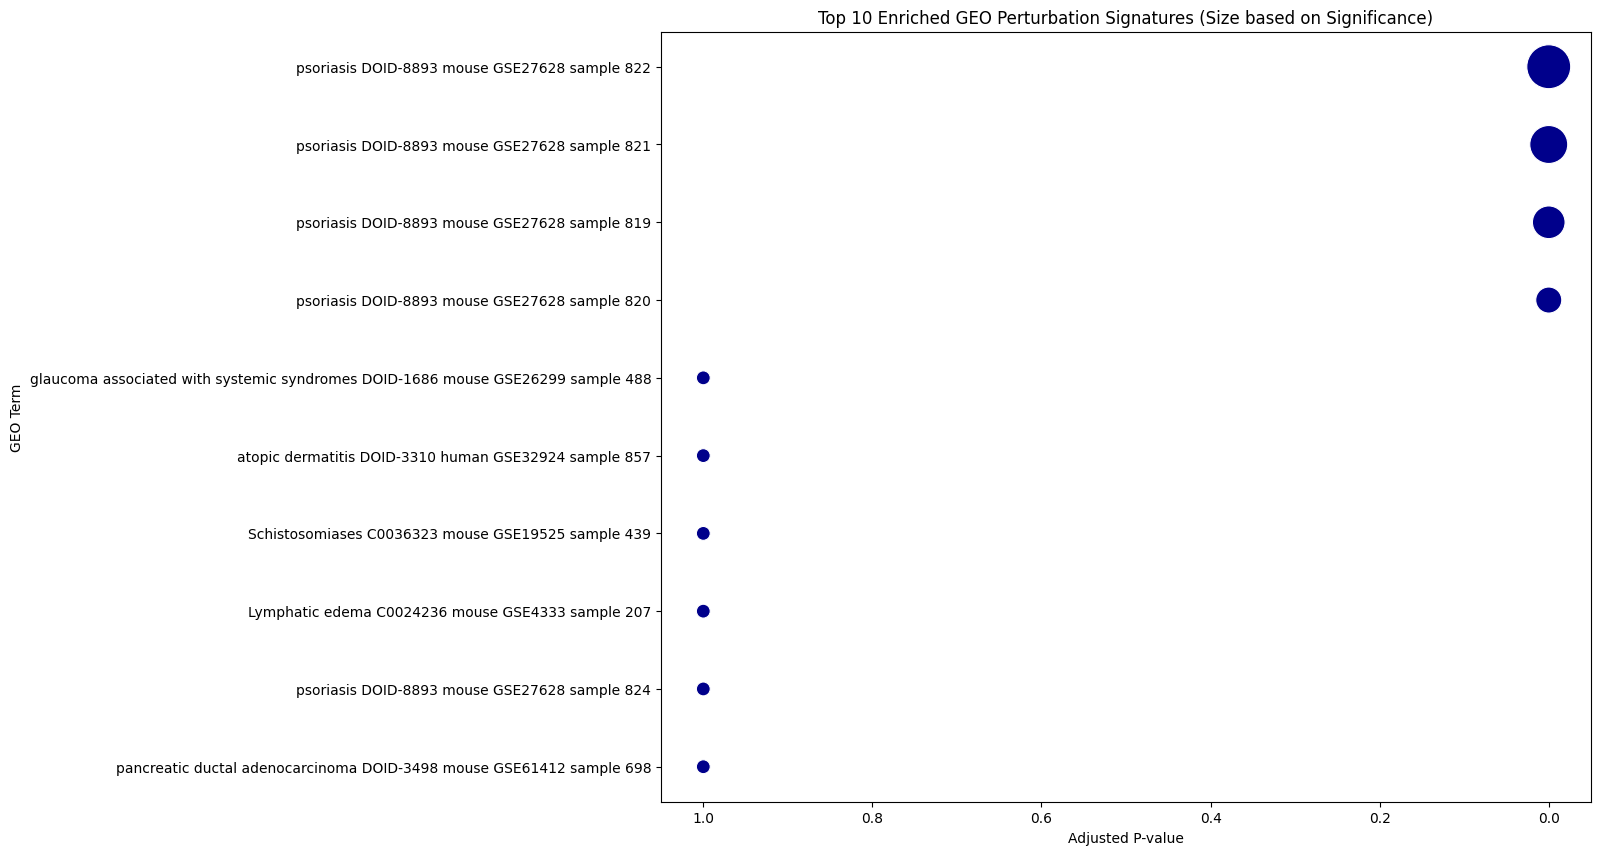

In [ ]:
# Plot top GEO up and down terms as dot plot with size representing significance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

geo_results = pd.concat([enrichr_results['GEO_down'], enrichr_results['GEO_up']], ignore_index=True)

if not geo_results.empty:
    # Add a column for plotting size based on -log10(Adjusted P-value)
    plot_data = enrichr['GEO_down'].res2d.head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])

    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='Adjusted P-value', y='Term', size='Significance', sizes=(100, 1000), \
                    data=plot_data, color='darkblue', legend=False) # sizes sets the range of dot sizes
    plt.title('Top 10 Enriched GEO Perturbation Signatures (Size based on Significance)')
    plt.xlabel('Adjusted P-value')
    plt.ylabel('GEO Term')
    plt.gca().invert_xaxis() # Invert x-axis to show smaller p-values at the top
    plt.savefig(GSEA_DIR + '/ora_geo_dotplot.png')

    plt.show()
else:
    print("No significant GEO terms found to plot.")

In [ ]:
# create lollipop plots for GO ORA results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if not enrichr_results['GO'].empty:
    '''plot_data = enrichr_results['GO'].head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])'''
    plot_data = enrichr['GO'].res2d.head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])
    plot_data = plot_data.sort_values('Adjusted P-value', ascending=True) # Sort for better visualization

    plt.figure(figsize=(10, 8))
    plt.hlines(y=plot_data['Term'], xmin=0, xmax=plot_data['Adjusted P-value'], color='skyblue')

    # Plot each point individually with its corresponding marker size
    for index, row in plot_data.iterrows():
        plt.plot(row['Adjusted P-value'], row['Term'], "o", markersize=row['Significance'] * 2, color='darkblue')

    plt.title('Top 10 Enriched GO Terms (Size based on Significance)')
    plt.xlabel('Adjusted P-value')
    plt.ylabel('GO Term')
    plt.gca().invert_xaxis() # Invert x-axis to show smaller p-values at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.savefig(GSEA_DIR + '/ora_go_lollipop.png')

    plt.show()
else:
    print("No significant GO terms found to plot.")

No significant GO terms found to plot.


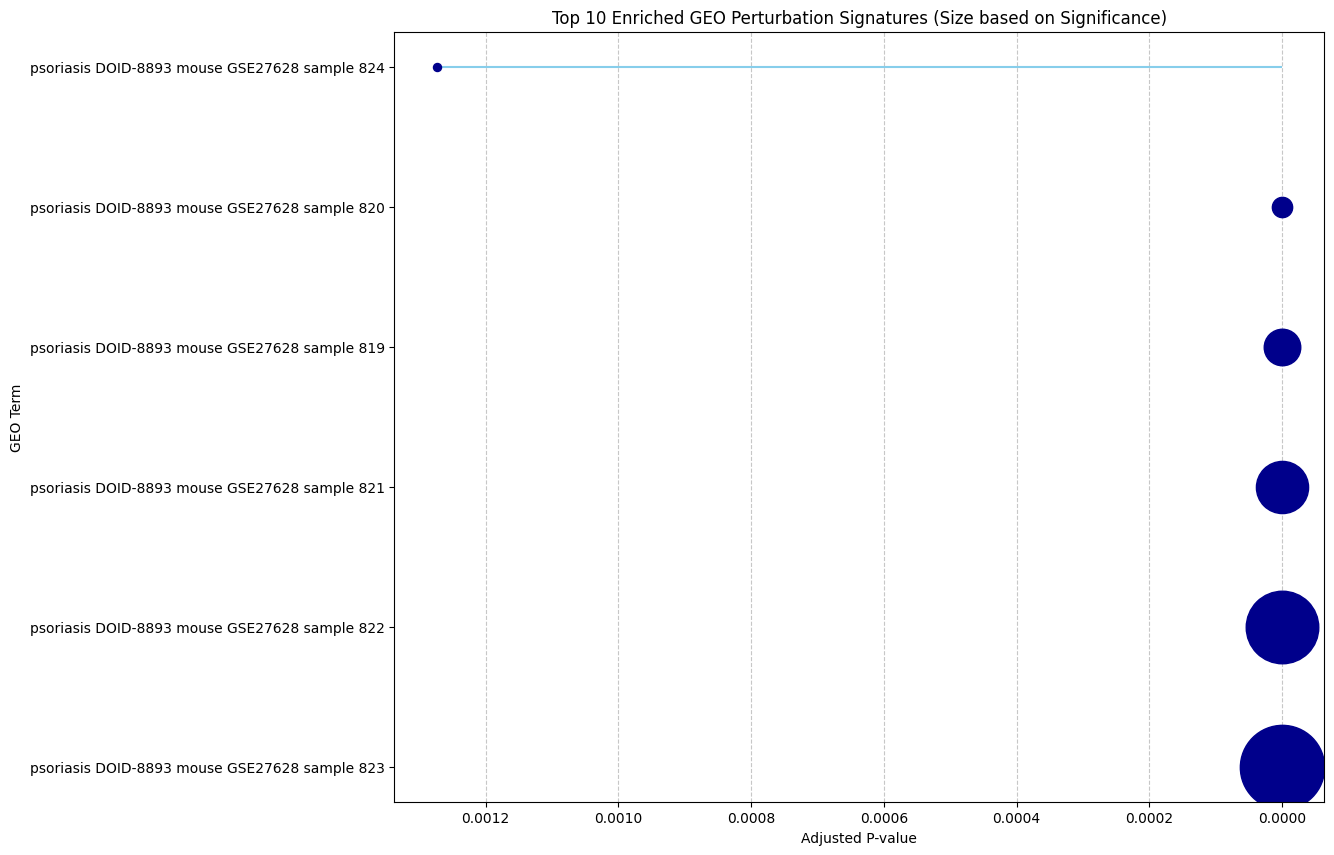

In [ ]:
# create lollipop plots for GEO ORA results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

geo_results = pd.concat([enrichr_results['GEO_down'], enrichr_results['GEO_up']], ignore_index=True)

if not geo_results.empty:
    plot_data = geo_results.head(10).copy()
    plot_data['Significance'] = -np.log10(plot_data['Adjusted P-value'])
    plot_data = plot_data.sort_values('Adjusted P-value', ascending=True) # Sort for better visualization

    plt.figure(figsize=(12, 10))
    plt.hlines(y=plot_data['Term'], xmin=0, xmax=plot_data['Adjusted P-value'], color='skyblue')

    # Plot each point individually with its corresponding marker size
    for index, row in plot_data.iterrows():
        plt.plot(row['Adjusted P-value'], row['Term'], "o", markersize=row['Significance'] * 2, color='darkblue')

    plt.title('Top 10 Enriched GEO Perturbation Signatures (Size based on Significance)')
    plt.xlabel('Adjusted P-value')
    plt.ylabel('GEO Term')
    plt.gca().invert_xaxis() # Invert x-axis to show smaller p-values at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.savefig(GSEA_DIR + '/ora_geo_lollipop.png')
    plt.show()

else:
    print("No significant GEO terms found to plot.")

# Verify notebook is complete before moving on

In [ ]:
# make sure your google drive disk space utilization is still under 15G
!du -sh /content/mnt/MyDrive/NASA/GL4HS

2.4G	/content/mnt/MyDrive/NASA/GL4HS


In [ ]:
# time the notebook
import datetime
end_time = datetime.datetime.now()
print('notebook end time: ', end_time.strftime('%Y-%m-%d %H:%M:%S'))

print('notebook runtime: ', end_time - start_time)

notebook end time:  2025-08-23 21:59:10
notebook runtime:  0:06:14.224100
